# Fraud Detection

## Installing important lIbraries
 * #### Numpy
 * #### Pandas
 * #### Seaborn
 * #### Scikit-learn
  

In [0]:
!pip install pandas
!pip install numpy
!pip install seaborn
!pip install scikit-learn

## Importing libraries

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import f1_score, confusion_matrix, classification_report, roc_auc_score
import sklearn
import matplotlib.pyplot as plt


## Loading The DATA
First, we will gone use memory reduce function to reduce the usage of the memory

In [0]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df



#### Loading Data

In [0]:
train_transaction = pd.read_csv('train/train_transaction.csv')
train_identity = pd.read_csv('train/train_identity.csv')

In [49]:
train = reduce_mem_usage(pd.merge(train_transaction, train_identity, on='TransactionID', how='left'))

del train_transaction
del train_identity

Memory usage of dataframe is 1959.88 MB
Memory usage after optimization is: 530.08 MB
Decreased by 73.0%


In [50]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


#### Checking the colums

In [21]:
train.columns

Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5',
       ...
       'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
       'DeviceType', 'DeviceInfo'],
      dtype='object', length=434)

#### Drop columns with null values greater than 20%

In [0]:
null_percent = train.isnull().sum()/train.shape[0]*100
cols_to_drop = np.array(null_percent[null_percent > 20].index)


In [0]:
train = train.drop(cols_to_drop, axis=1)

#### Filling the Null Values

In [0]:
null_percent = train.isnull().sum()/train.shape[0]*100
null_cols = np.array(null_percent[null_percent > 0].index)

In [16]:
for i in null_cols:
    print('data type of {} is {}'.format(i, str(train[i].dtype)))
    train[i] = train[i].replace(np.nan, train[i].mode()[0])
    print('Filled the null values of column {}'.format(i))
    print('--------------------------------------------')

data type of card2 is float16
Filled the null values of column card2
--------------------------------------------
data type of card3 is float16
Filled the null values of column card3
--------------------------------------------
data type of card4 is category
Filled the null values of column card4
--------------------------------------------
data type of card5 is float16
Filled the null values of column card5
--------------------------------------------
data type of card6 is category
Filled the null values of column card6
--------------------------------------------
data type of addr1 is float16
Filled the null values of column addr1
--------------------------------------------
data type of addr2 is float16
Filled the null values of column addr2
--------------------------------------------
data type of P_emaildomain is category
Filled the null values of column P_emaildomain
--------------------------------------------
data type of D1 is float16
Filled the null values of column D1
------

#### Generate X and Y

In [18]:
X = train.drop('isFraud', axis=1)
y = train['isFraud']
X.shape

(590540, 181)

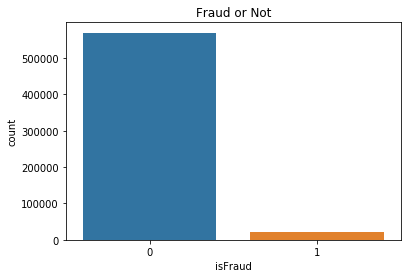

In [57]:
sns.countplot(x=y)
plt.title('Fraud or Not')
plt.show()

#### Handling categorical data

In [21]:
num_cols = X._get_numeric_data().columns
cat_cols=list(set(X.columns) - set(num_cols))
len(cat_cols)

4

In [0]:
X=pd.get_dummies(X, columns=cat_cols)

#### Selecting columns Based on correlation

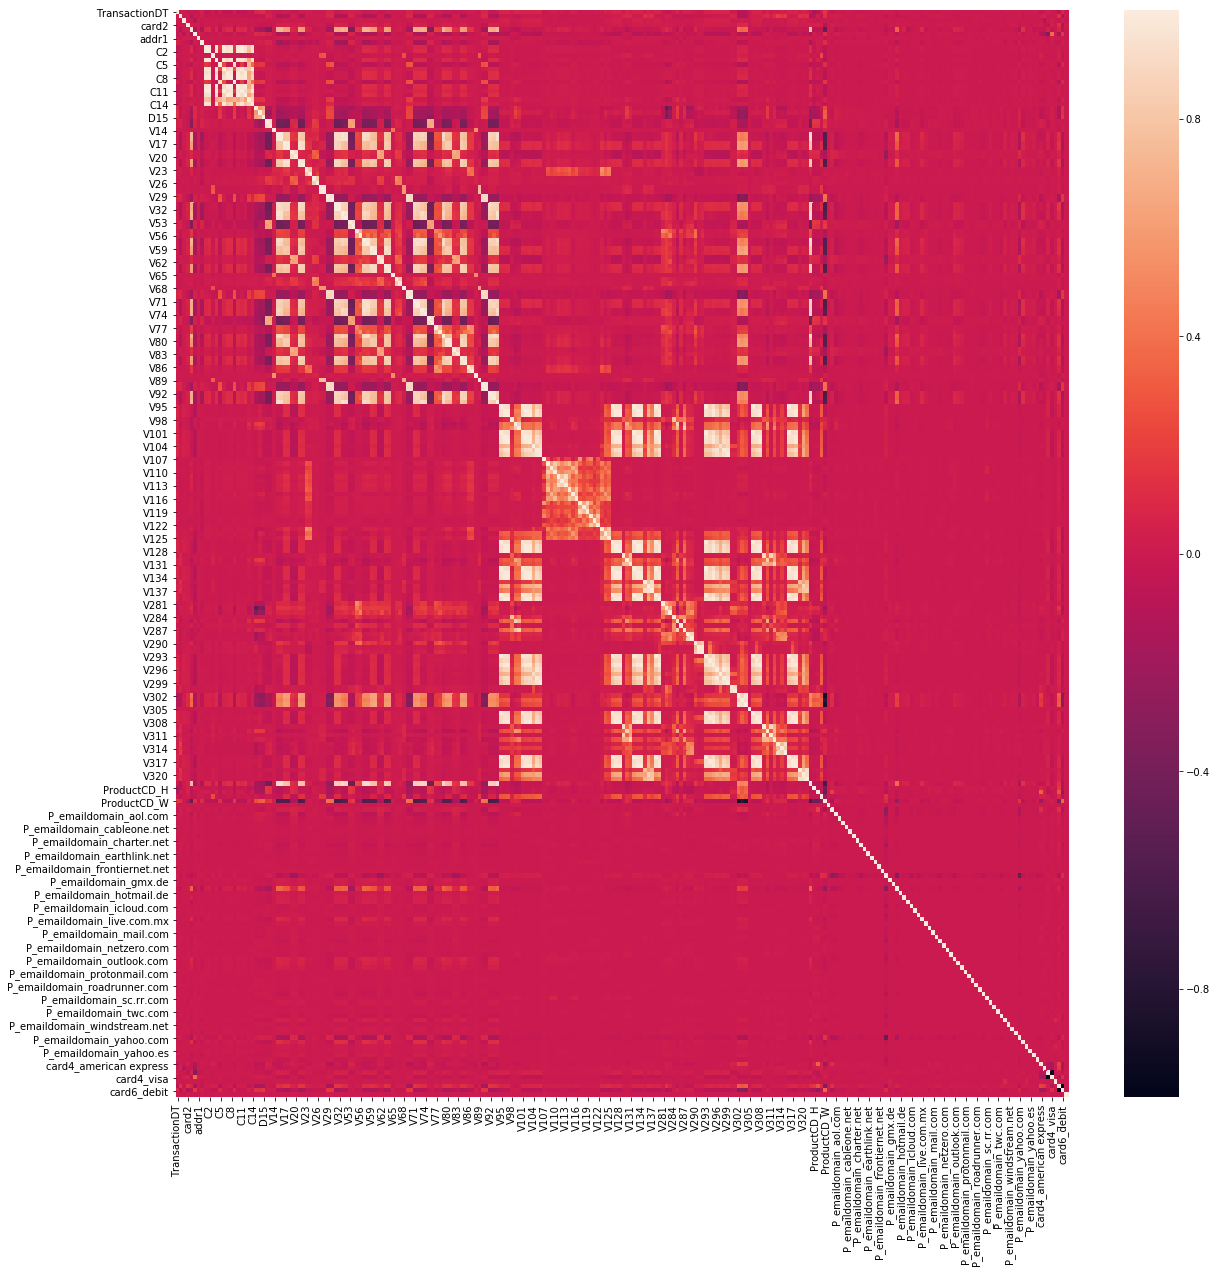

In [56]:
c = X.corr()
plt.figure(figsize=(20,20))
sns.heatmap(c)

In [0]:
col_corr = set()
for i in range(len(c.columns)):
    for j in range(i):
        if (c.iloc[i, j] >= 0.95) and (c.columns[j] not in col_corr):
            colname = c.columns[i] 
            col_corr.add(colname)


In [27]:
cols = X.columns
print('{} and {}'.format(len(cols), len(col_corr)))


248 and 49


In [0]:
final_columns = []

for i in cols:
    if i in col_corr:
        continue
    else:
        final_columns.append(i)

In [0]:
X1 = X[final_columns]

### Train Model

In [30]:
X.shape,y.shape

((590540, 248), (590540,))

In [0]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X1,y, test_size=0.25, random_state=25678)

#### Grid search the parameters

In [0]:
from sklearn.linear_model import LogisticRegression

In [0]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
clf = GridSearchCV(LogisticRegression(penalty='l2'), param_grid)

In [37]:
clf.fit(x_train,y_train)
print("tuned hpyerparameters :(best parameters) ",clf.best_params_)
print("accuracy :",clf.best_score_)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Sp

tuned hpyerparameters :(best parameters)  {'C': 0.001}
accuracy : 0.964881859540985


#### Train 

In [45]:
logisticRegr = LogisticRegression(penalty='l2',C= 0.001)
logisticRegr.fit(x_train,y_train)
print("score",logisticRegr.score(x_test,y_test))


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


score 0.9652182747993362
